<a href="https://colab.research.google.com/github/szilaard/AIT_project/blob/main/AitProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIT Deep Learning Project

Péter Czumbel

Szilárd Horváth


In [1]:
import tensorflow as tf
import librosa
import pandas as pd
from glob import glob
import IPython
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt

Downloading the GTZAN dataset from tensorflow datasets doesn't work, the URL times out.<br>
See: https://github.com/tensorflow/datasets/issues/4090 <br>
Using [this](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification) version of the dataset from kaggle instead.



We read all the data from the directories with glob.

In [14]:
audio_files = glob("Data/genres_original/*/*.wav")

Example audio:

In [3]:
ipd.Audio(audio_files[0])

We read the raw data of the first audio sample and its sample frequency

Y is a numpy array: [ 0.00732422  0.01660156  0.00762939 ... -0.05560303 -0.06106567
 -0.06417847]
Shape of Y: (661794,)
Sample Rate: 22050


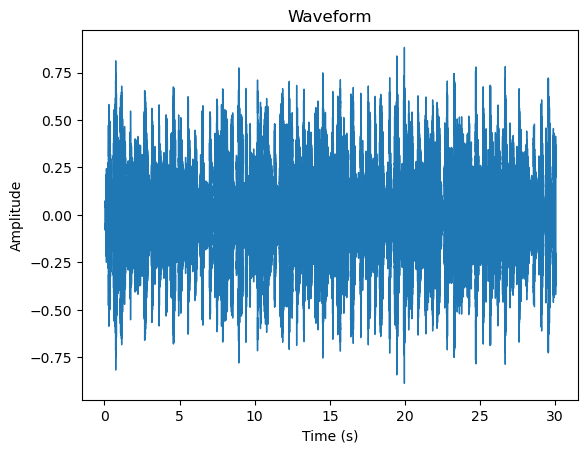

In [18]:
signal, sr = librosa.load(audio_files[0], sr=22050)
print("Y is a numpy array:", signal)
print("Shape of Y:", signal.shape)
print("Sample Rate:", sr)

librosa.display.waveshow(signal, sr=sr)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")
plt.show()

Short-time Fourier transformation

New shape of transformed data (1025, 1293)


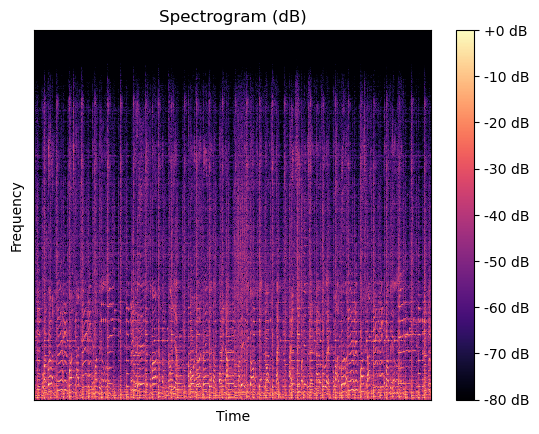

In [17]:
n_fft = 2048
hop_length = 512
stft = librosa.stft(signal, hop_length=hop_length, n_fft=n_fft)
spectrogram = np.abs(stft)
log_spectrogram = librosa.amplitude_to_db(spectrogram, ref=np.max)

print("New shape of transformed data", log_spectrogram.shape)

librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")
plt.show()